In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words
from wordcloud import WordCloud

# Download necessary NLTK packages
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
df = pd.read_csv('dataset/Resume/Resume.csv')
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


In [4]:
df.drop(columns = ['Resume_html'], inplace = True)
df.head()

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


# ATTENZIONE !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
La riga 656 ha il campo 'Resume_str' vuoto ma df.info() non lo rileva.
Ho quindi aggiunto del codice per rimuovere tutte le righe che hanno Resume_str vuoto o NaN

In [5]:
print(df[df.index == 656].head(1))

           ID             Resume_str              Category
656  12632728                         BUSINESS-DEVELOPMENT


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          2484 non-null   int64 
 1   Resume_str  2484 non-null   object
 2   Category    2484 non-null   object
dtypes: int64(1), object(2)
memory usage: 58.3+ KB


In [7]:
# Remove rows where 'Resume_str' is NaN or empty
df = df[df['Resume_str'].notna()]  # Remove NaN values
df = df[df['Resume_str'].str.strip() != '']  # Remove empty strings

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2483 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          2483 non-null   int64 
 1   Resume_str  2483 non-null   object
 2   Category    2483 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.6+ KB


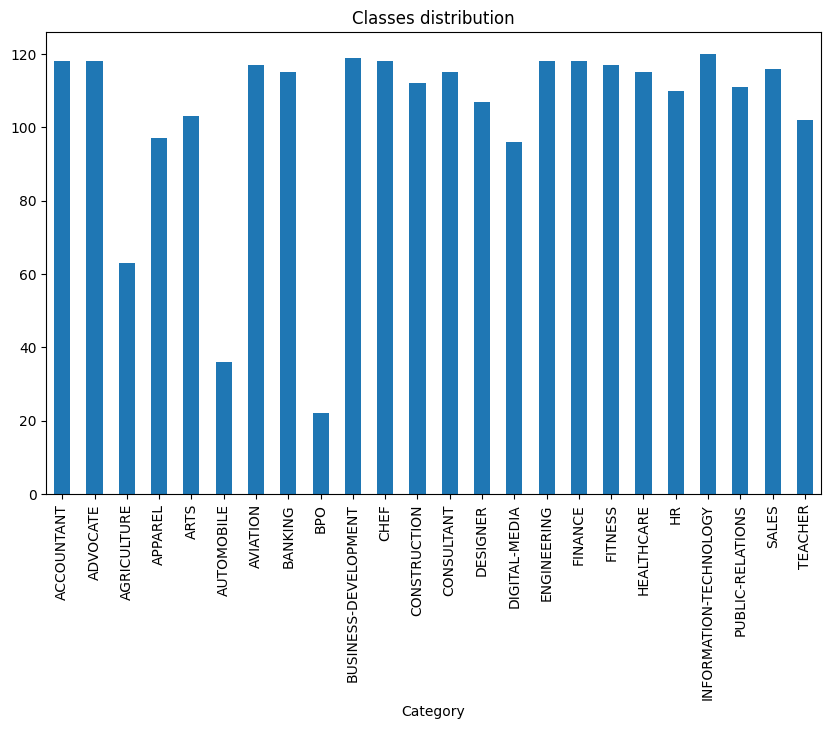

In [9]:
df['Category'].value_counts().sort_index().plot(kind='bar', title='Classes distribution', figsize=(10,6))
plt.show()

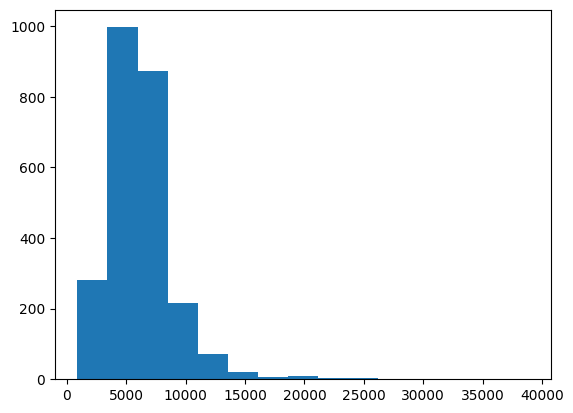

In [10]:
# Create a histogram to visualize how the lengths of resumes (in number of characters) are distributed
plt.hist([len(x) for x in df.Resume_str], bins = 15)
plt.show()

## Preprocessing

In [11]:
# Get the list of valid English words
english_words = set(words.words())

# Get a list of stop word
stop_words = set(nltk.corpus.stopwords.words('english'))

# Initialize the stemmer
stemmer = PorterStemmer()

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

In [12]:
def preprocess_text(text, remove_numbers=True, use_dictionary=True, use_lemmatization=False, use_stemming=True):
    """
    Preprocesses the text: 
    - Converts to lowercase
    - Removes punctuation
    - Tokenizes
    - Removes stopwords
    - Removes words with numbers (if enabled)
    - Uses dictionary filtering (if enabled)
    - Applies lemmatization or stemming based on parameters
    """
    
    text = text.lower()                         # Convert to lowercase
    text = re.sub(r'[^\w\s]', ' ', text)         # TODO non ho capito perchè commantando diminuiscono i token     # Remove all punctuation  
    text = re.sub(r'\s+', ' ', text).strip()    # Remove multiple spaces
    
    tokens = word_tokenize(text) # Tokenize the text

    processed_tokens = []
    
    for token in tokens:
        # Remove words containing numbers (if enabled)
        if remove_numbers and any(char.isdigit() for char in token):
            continue

        # Dictionary filtering (if enabled)
        if use_dictionary and token not in english_words:
            continue

        # Remove stopwords
        if token in stop_words:
            continue

        if use_lemmatization:
            token = lemmatizer.lemmatize(token)
        elif use_stemming:
            token = stemmer.stem(token)

        processed_tokens.append(token)
        
        # Check if the token contains only letters/numbers
        # if re.fullmatch(r'[a-zA-Z0-9]+', token):              # not usefull if use_dictionary = True

        # Exclude stopwords
        # if token not in stop_words and not token.isdigit():
        #     # If requested, check if it is in the English dictionary or is a number
        #     if use_dictionary:
        #         if token in english_words:   # TODO probably, in classification, it's not necessary to have the digits
        #             # stemmed = stemmer.stem(token)
        #             lemmed = lemmatizer.lemmatize(token)      # TODO try lemmatizer instead stemmer, it could improve performance
        #             processed_tokens.append(lemmed)
        #     else:
        #         # stemmed = stemmer.stem(token)
        #         lemmed = lemmatizer.lemmatize(token)          # TODO try lemmatizer instead stemmer, it could improve performance
        #         processed_tokens.append(lemmed)
        # # If the token is not valid, discard it

    
    #tokens = remove_non_english(tokens)    # Remove non-English words
    
    return ' '.join(processed_tokens)


In [13]:
from tqdm import tqdm  # Library for the progress bar

def preprocess_text_with_progress(df, column_name, **kwargs):
    """
    Applies preprocess_text to a DataFrame column with a progress bar.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the data
    - column_name (str): Name of the column to preprocess
    - kwargs: Parameters to pass to the preprocess_text function
    
    Returns:
    - pd.Series: Series containing the preprocessed texts
    """
    tqdm.pandas(desc="Processing Resumes")  # Enable tqdm for Pandas
    return df[column_name].progress_apply(lambda x: preprocess_text(x, **kwargs))

In [14]:
import itertools
import os
parameter_sets = [
    {"remove_numbers": True, "use_dictionary": False, "use_lemmatization": False, "use_stemming": False},
    {"remove_numbers": False, "use_dictionary": True, "use_lemmatization": False, "use_stemming": False},
    {"remove_numbers": True, "use_dictionary": True, "use_lemmatization": False, "use_stemming": False},
    {"remove_numbers": True, "use_dictionary": True, "use_lemmatization": False, "use_stemming": True},
    {"remove_numbers": True, "use_dictionary": True, "use_lemmatization": True, "use_stemming": False},
    {"remove_numbers": True, "use_dictionary": True, "use_lemmatization": True, "use_stemming": True}
]

In [15]:
for params in parameter_sets:
    # Create a copy of the original DataFrame
    df_copy = df.copy()

    # Apply preprocessing with the current parameter combination
    df_copy['Resume_str'] = preprocess_text_with_progress(df_copy, 'Resume_str', **params)

    # Define the folder where CSV files will be saved
    output_folder = "processed_data"
    
    # Ensure the folder exists (create it if necessary)
    os.makedirs(output_folder, exist_ok=True)
    
    # Generate the full path for saving the file
    filename = os.path.join(output_folder, "Resume_processed_" + "_".join([f"{key}={value}" for key, value in params.items()]) + ".csv")
    
    # Save the DataFrame to the specified folder
    df_copy.to_csv(filename, index=False)

    print(f"Processed DataFrame saved as: {filename}")

Processing Resumes: 100%|█████████████████████████████████████████████████████████| 2483/2483 [00:20<00:00, 123.52it/s]


Processed DataFrame saved as: processed_data\Resume_processed_remove_numbers=True_use_dictionary=False_use_lemmatization=False_use_stemming=False.csv


Processing Resumes: 100%|█████████████████████████████████████████████████████████| 2483/2483 [00:18<00:00, 135.83it/s]


Processed DataFrame saved as: processed_data\Resume_processed_remove_numbers=False_use_dictionary=True_use_lemmatization=False_use_stemming=False.csv


Processing Resumes: 100%|█████████████████████████████████████████████████████████| 2483/2483 [00:21<00:00, 118.09it/s]


Processed DataFrame saved as: processed_data\Resume_processed_remove_numbers=True_use_dictionary=True_use_lemmatization=False_use_stemming=False.csv


Processing Resumes: 100%|██████████████████████████████████████████████████████████| 2483/2483 [01:02<00:00, 39.68it/s]


Processed DataFrame saved as: processed_data\Resume_processed_remove_numbers=True_use_dictionary=True_use_lemmatization=False_use_stemming=True.csv


Processing Resumes: 100%|██████████████████████████████████████████████████████████| 2483/2483 [00:41<00:00, 60.55it/s]


Processed DataFrame saved as: processed_data\Resume_processed_remove_numbers=True_use_dictionary=True_use_lemmatization=True_use_stemming=False.csv


Processing Resumes: 100%|██████████████████████████████████████████████████████████| 2483/2483 [00:33<00:00, 74.79it/s]


Processed DataFrame saved as: processed_data\Resume_processed_remove_numbers=True_use_dictionary=True_use_lemmatization=True_use_stemming=True.csv
